In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from caviar import CaviarModel
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test, traffic_light_test
from backtesting import backtest

In [3]:
while True:
    data = yf.download('SPY AAPL MSFT JPM KO', start='2001-01-01')
    if data.shape[0] > 0:
        break

[*********************100%***********************]  5 of 5 completed


In [4]:
log_returns = (data['Close'].apply(np.log).diff() * 100).dropna()

In [5]:
low_open_log_difference = (
    (data['Low'].apply(np.log) - data['Open'].apply(np.log))
).dropna()

In [6]:
out_low_open_diff = low_open_log_difference['2016':]

In [7]:
in_samples = log_returns[:'2015']
out_samples = log_returns['2016':]

In [8]:
q = 0.05
mod = 'adaptive'
method_fit = 'mle'

D:\CAViaR-Project\test\..\caviar\_caviar_function.py:22: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(G * (returns[t] - VaRs[t]))) - quantile


Final loss: 0.25677642294821157
Time taken(s): 1.69


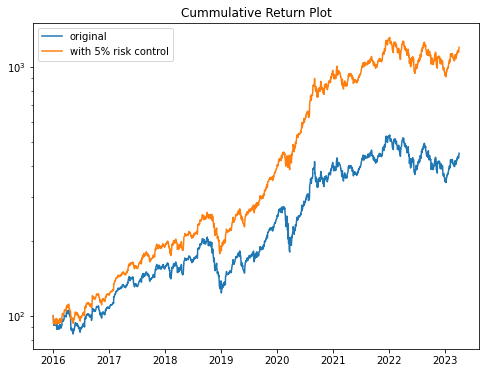

Final loss: 0.24232761250901708
Time taken(s): 1.57


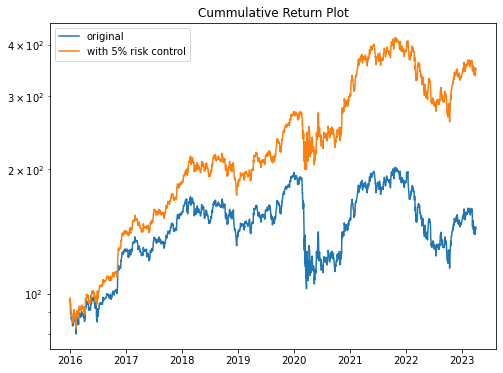

Final loss: 0.12908546725292738
Time taken(s): 2.83


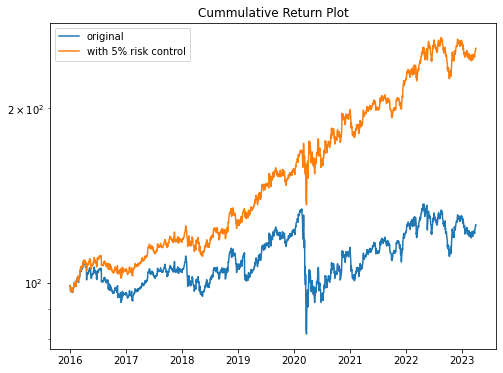

D:\CAViaR-Project\test\..\caviar\_caviar_function.py:22: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(G * (returns[t] - VaRs[t]))) - quantile


Final loss: 0.19367050559132448
Time taken(s): 1.59


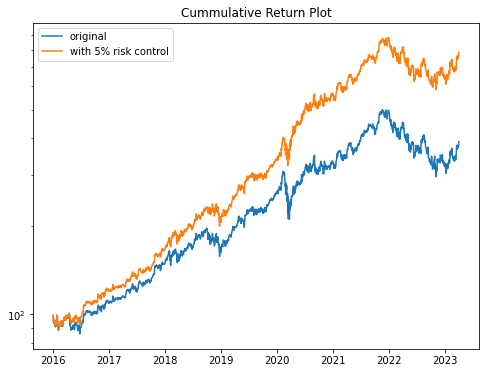

D:\CAViaR-Project\test\..\caviar\_caviar_function.py:22: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(G * (returns[t] - VaRs[t]))) - quantile


Final loss: 0.12817363708616467
Time taken(s): 7.50


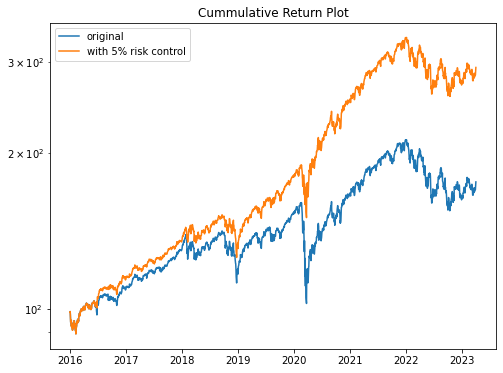

In [9]:
stat_df = []

for ticker in log_returns.columns:
    caviar_model = CaviarModel(quantile=q, model=mod, method=method_fit)
    caviar_model.fit(in_samples[ticker])
    # we only want day 0 to T as the return are from day 0 to T
    # so drop the last forecast
    out_VaRs = caviar_model.predict(out_samples[ticker], caviar_model.VaR0_out)[:-1]
    stat1, stat2, stat3, stat4, stat5, stat6 = backtest(out_samples[ticker], out_low_open_diff[ticker], out_VaRs, q)
    stat_df.append({
        'ticker': ticker,
        'annualized_return_with_CAViaR': stat1,
        'cumulative_return_with_CAViaR': stat2,
        'maximum_drawdown_with_CAViaR': stat3,
        'annualized_return_w/o_CAViaR': stat4,
        'cumulative_return_w/o_CAViaR': stat5,
        'maximum_drawdown_w/o_CAViaR': stat6,
    })

In [15]:
pd.DataFrame(stat_df)

,ticker,annualized_return_with_CAViaR,cumulative_return_with_CAViaR,maximum_drawdown_with_CAViaR,annualized_return_w/o_CAViaR,cumulative_return_w/o_CAViaR,maximum_drawdown_w/o_CAViaR
0,AAPL,0.409080,10.967675,-0.317335,0.230791,3.495333,-0.403706
1,JPM,0.189282,2.506856,-0.375251,0.052393,0.447195,-0.476386
2,KO,0.137282,1.537340,-0.215979,0.032363,0.259273,-0.391186
3,MSFT,0.329136,6.841651,-0.335140,0.206310,2.886935,-0.410032
4,SPY,0.159787,1.923983,-0.230478,0.081042,0.757745,-0.361400
